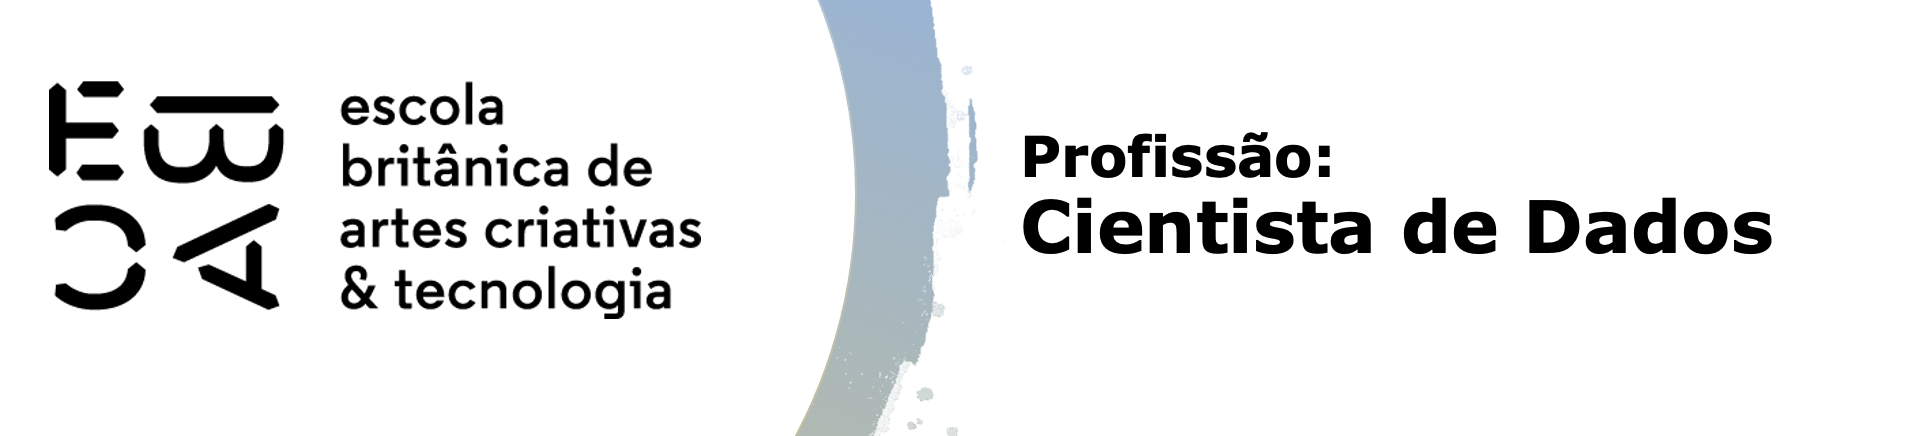

# Árvores II - Tarefa 3

### 1. Carregar as bases

Vamos utilizar nesta tarefa as bases de reconhecimento de atividade humana através do celular. Carregue novamente as bases salvas na tarefa I.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from pathlib import Path
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix

In [12]:
base_dir = Path(r"C:\Users\Priscila\Desktop\EBAC - DATA SCIENCE\Desenvolvimento Modelos com Pandas e Python\Árvores II\Pratique III\input")

X_train = pd.read_csv(base_dir / "X_train.csv", index_col=[0, 1])
X_test  = pd.read_csv(base_dir / "X_test.csv",  index_col=[0, 1])

y_train = pd.read_csv(base_dir / "y_train.csv", index_col=[0, 1]).squeeze("columns")
y_test  = pd.read_csv(base_dir / "y_test.csv",  index_col=[0, 1]).squeeze("columns")

display(X_train.head())
print("X_train (linhas, colunas):", X_train.shape)
print("X_test  (linhas, colunas):", X_test.shape)
print("y_train (linhas):", y_train.shape[0])
print("y_test  (linhas):", y_test.shape[0])

,,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject
ordem,sujeito,,,,,,,,,,,,,,,,,,,,,
0,1,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1
1,1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1
2,1,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1
3,1,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1
4,1,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1


X_train (linhas, colunas): (7352, 562)
X_test  (linhas, colunas): (2947, 562)
y_train (linhas): 7352
y_test  (linhas): 2947


### 2. Calcule os ```ccp_alphas```. 

Vamos seguir uma lógica bem em linha com o que já estamso acostumados, com as seguintes orientações:

- Utilizar treinamento e teste conforme já vieram definidos originalmente
- Por pragmatismo, utilizar ```min_samples_leaf=20```
- Utilize as mesmas "3 melhores variáveis" identificadas no exercício anterior.

In [13]:
%%time
# 3 melhores variáveis encontradas
cols_3 = ["tGravityAcc-min()-X", "fBodyAcc-mad()-X", "angle(Y,gravityMean)"]

# garantir que elas existem no dataframe
faltando = [c for c in cols_3 if c not in X_train.columns]
if faltando:
    raise ValueError(f"Essas colunas não estão em X_train: {faltando}")

Xtr3 = X_train[cols_3].copy()
Xte3 = X_test[cols_3].copy()

display(Xtr3.head())
print("Xtr3 (linhas, colunas):", Xtr3.shape)
print("Xte3 (linhas, colunas):", Xte3.shape)
print("y_train (linhas):", y_train.shape[0])
print("y_test  (linhas):", y_test.shape[0])

# árvore base só para calcular o caminho de poda
arvore_base = DecisionTreeClassifier(min_samples_leaf=20, random_state=42)
arvore_base.fit(Xtr3, y_train)

path = arvore_base.cost_complexity_pruning_path(Xtr3, y_train)
ccp_alphas = np.unique(path.ccp_alphas[path.ccp_alphas > 0])  # positivos e únicos

print("Total de ccp_alphas (positivos e únicos):", ccp_alphas.shape[0])
print("Menor ccp_alpha:", ccp_alphas.min() if ccp_alphas.size else None)
print("Maior ccp_alpha:", ccp_alphas.max() if ccp_alphas.size else None)

# para acelerar: pegar 1 a cada 5
ccp_alphas_sub = ccp_alphas[::5]
print("Total após slicing [::5]:", ccp_alphas_sub.shape[0])
print("Primeiros 10:", ccp_alphas_sub[:10])


,,tGravityAcc-min()-X,fBodyAcc-mad()-X,"angle(Y,gravityMean)"
ordem,sujeito,,,
0,1,0.977436,-0.996889,0.179941
1,1,0.984520,-0.997890,0.180289
2,1,0.986770,-0.994097,0.180637
3,1,0.986821,-0.994547,0.181935
4,1,0.987434,-0.997725,0.185151


Xtr3 (linhas, colunas): (7352, 3)
Xte3 (linhas, colunas): (2947, 3)
y_train (linhas): 7352
y_test  (linhas): 2947
Total de ccp_alphas (positivos e únicos): 104
Menor ccp_alpha: 6.599064264795887e-06
Maior ccp_alpha: 0.1861382417305819
Total após slicing [::5]: 21
Primeiros 10: [6.59906426e-06 8.99098135e-06 2.48717550e-05 3.97453471e-05
 5.87197700e-05 1.03726254e-04 1.29216540e-04 2.11135039e-04
 2.46949304e-04 2.85903262e-04]
CPU times: total: 46.9 ms
Wall time: 34 ms


### 3. *Grid Search*

Vou deixar especificações iniciais mínimas, que visam limitar o tempo de máquina, pois um procedimento desses pode demorar muito tempo dependendo da especificação. Mas conforme você for ficando confortável com o tempo consumido pelo procedimento, pode fazer um algoritmo mais exaustivo, por exemplo, avaliando mais valores de ```ccp_alpha```.

- Meça o tempo
- Utilize a base de treinamento
- Utilize um *cross validation* do tipo *k-fold*, especifique k=10
- Você pode ler 1 a cada ```k``` valores para uma melhor varredura utilizando, por exemplo, ```ccp_alpha[::10]```
- Não se esqueça de limitar o número de variáveis

In [33]:
%%time
# k-fold estratificado
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# árvore base (mantendo min_samples_leaf=20)
dt = DecisionTreeClassifier(min_samples_leaf=20, random_state=42)

# grid só no ccp_alpha
param_grid = {"ccp_alpha": ccp_alphas_sub.astype(float)}

grid = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1,
    return_train_score=True
)

grid.fit(Xtr3, y_train)

df_cv = pd.DataFrame(grid.cv_results_)[
    ["param_ccp_alpha", "mean_train_score", "mean_test_score", "std_test_score", "rank_test_score"]
].rename(columns={
    "param_ccp_alpha": "ccp_alpha",
    "mean_train_score": "acc_treino_media",
    "mean_test_score": "acc_validacao_media",
    "std_test_score": "std_validacao",
    "rank_test_score": "rank"
}).sort_values("ccp_alpha").reset_index(drop=True)

display(df_cv.head())
print("Melhor ccp_alpha:", float(grid.best_params_["ccp_alpha"]))
print("Acurácia média (validação - CV):", grid.best_score_)


,ccp_alpha,acc_treino_media,acc_validacao_media,std_validacao,rank
0,0.000007,0.907992,0.879211,0.012239,18
1,0.000031,0.907992,0.879211,0.012239,18
2,0.000044,0.907992,0.879211,0.012239,18
3,0.000051,0.907992,0.879211,0.012239,18
4,0.000057,0.907992,0.879211,0.012239,18


Melhor ccp_alpha: 0.00022244581970295822
Acurácia média (validação - CV): 0.8800271739130434
CPU times: total: 516 ms
Wall time: 4.86 s


### 4. Avaliando a árvore

- Obtenha a árvore na melhor configuração treinada em toda a base de treino
- Calcule a acurácia dessa árvore na base de testes
- Visualize a matriz de confusão

Acurácia no teste: 0.7265015269765863


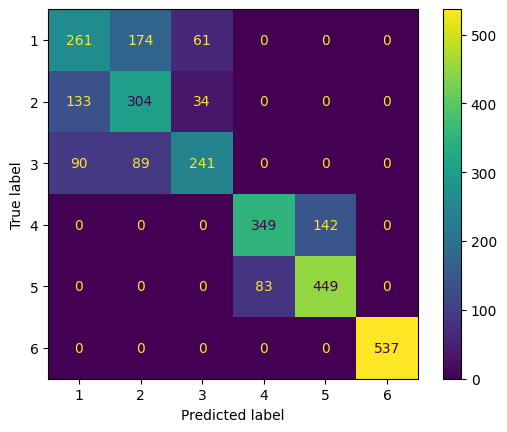

In [15]:
# definir de novo as 3 variáveis
top3_vars = ["tGravityAcc-min()-X", "fBodyAcc-mad()-X", "angle(Y,gravityMean)"]

best_tree = grid.best_estimator_

Xte3 = X_test[top3_vars].copy()

y_pred = best_tree.predict(Xte3)
acc_test = accuracy_score(y_test, y_pred)

print("Acurácia no teste:", acc_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()



### 5. Melhorando a árvore

A melhor forma de se melhorar um algoritmo é colocando nele novas variáveis que agreguem valor. Podemos usar a força-bruta e ir colocando variáveis aleatoriamente - ou colocar todas e deixar rodando por um bom tempo - ou utilizar uma lógica eficiente e fazer uma seleção de variáveis.

- Observe que há classes mais fáceis e mais difíceis de se identificar
- Crie uma variável binária para uma das classes de maior erro
- Fala uma árvore de classificação bem simples para esta variável:
    - utilize ```mean_samples_leaf=20```
    - utilize ```max_depth=4```
    - coloque todas as variáveis
- Observe a importância das variáveis, e selecione as 3 com maior importância
- Rode novamente o algoritmo acima com as 3 novas variáveis e avalie a acurácia

,classe,recall,acertos,total
0,1,0.526210,261,496
1,3,0.573810,241,420
2,2,0.645435,304,471
3,4,0.710794,349,491
4,5,0.843985,449,532
5,6,1.000000,537,537


Classe mais difícil (menor recall): 1
Classe mais fácil (maior recall): 6
Classe escolhida para binário: 1
Proporção de 1 no treino: 0.16675734494015235


,variavel,importancia
0,fBodyAccMag-std(),0.352379
1,tBodyGyroJerk-mad()-X,0.352154
2,"tGravityAcc-arCoeff()-X,1",0.113027
3,tBodyAccMag-arCoeff()1,0.036619
4,fBodyGyro-maxInds-X,0.030157
5,"tBodyAcc-correlation()-X,Y",0.028273
6,tBodyGyroMag-entropy(),0.025598
7,tBodyAccJerk-entropy()-Z,0.023826
8,"tBodyAccJerk-correlation()-X,Y",0.016503
9,"tGravityAcc-arCoeff()-X,2",0.014936


Top 3 novas variáveis: ['fBodyAccMag-std()', 'tBodyGyroJerk-mad()-X', 'tGravityAcc-arCoeff()-X,1']
Total de ccp_alphas (positivos e únicos): 185
Total após slicing [::5]: 37


,ccp_alpha,acc_treino_media,acc_validacao_media,std_validacao,rank
0,0.000007,0.753355,0.651944,0.04899,32
1,0.000031,0.753355,0.651944,0.04899,32
2,0.000044,0.753355,0.651944,0.04899,32
3,0.000051,0.753325,0.652080,0.04883,29
4,0.000057,0.753295,0.652080,0.04883,29


Melhor ccp_alpha: 0.0007215344018094635
Acurácia média (validação - CV): 0.6648680124223604
Tempo (segundos): 0.92
Acurácia no teste (3 novas variáveis): 0.6861214794706482


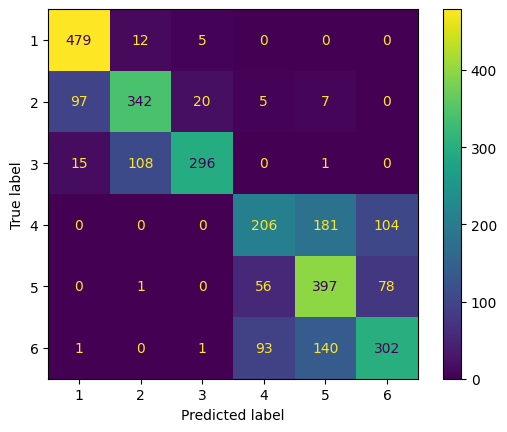

In [32]:
# Achar classes mais fáceis/difíceis

X_test3_old = X_test[top3_vars].copy()
y_pred_old = best_tree.predict(X_test3_old)

cm_old = confusion_matrix(y_test, y_pred_old)
classes = np.unique(y_test)

recall_por_classe = np.diag(cm_old) / cm_old.sum(axis=1)

df_rec = pd.DataFrame({
    "classe": classes,
    "recall": recall_por_classe,
    "acertos": np.diag(cm_old),
    "total": cm_old.sum(axis=1)
}).sort_values("recall").reset_index(drop=True)

display(df_rec.head(10))
classe_dificil = int(df_rec.loc[0, "classe"])
classe_facil = int(df_rec.loc[df_rec.index[-1], "classe"])
print("Classe mais difícil (menor recall):", classe_dificil)
print("Classe mais fácil (maior recall):", classe_facil)


# Criar variável binária para a classe de maior erro

y_train_bin = (y_train == classe_dificil).astype(int)
y_test_bin  = (y_test  == classe_dificil).astype(int)

print("Classe escolhida para binário:", classe_dificil)
print("Proporção de 1 no treino:", float(y_train_bin.mean()))

# Árvore simples para o binário (todas as variáveis)
# min_samples_leaf=20 e max_depth=4

clf_bin = DecisionTreeClassifier(
    random_state=42,
    min_samples_leaf=20,
    max_depth=4
)
clf_bin.fit(X_train, y_train_bin)

# Importância das variáveis -> pegar TOP 3 novas

imp = pd.Series(clf_bin.feature_importances_, index=X_train.columns).sort_values(ascending=False)
df_imp = imp.reset_index()
df_imp.columns = ["variavel", "importancia"]

display(df_imp.head(10))
top3_novas = df_imp["variavel"].head(3).tolist()
print("Top 3 novas variáveis:", top3_novas)


# Rodar novamente o procedimento (ccp_alpha + GridSearch)
# agora com as 3 NOVAS variáveis e avaliar acurácia

Xtr3_new = X_train[top3_novas].copy()
Xte3_new = X_test[top3_novas].copy()

# calcular ccp_alphas usando min_samples_leaf=20 
arvore_base = DecisionTreeClassifier(random_state=42, min_samples_leaf=20)
arvore_base.fit(Xtr3_new, y_train)

path = arvore_base.cost_complexity_pruning_path(Xtr3_new, y_train)
ccp_alphas = np.unique(path.ccp_alphas)
ccp_alphas = ccp_alphas[ccp_alphas > 0]  # só positivos

# para acelerar: pegar 1 a cada 5
ccp_alphas_sub = ccp_alphas[::5]

print("Total de ccp_alphas (positivos e únicos):", int(ccp_alphas.shape[0]))
print("Total após slicing [::5]:", int(ccp_alphas_sub.shape[0]))

param_grid = {"ccp_alpha": ccp_alphas_sub}

t0 = time.time()
grid_new = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42, min_samples_leaf=20),
    param_grid=param_grid,
    scoring="accuracy",
    cv=10,
    n_jobs=-1,
    return_train_score=True
)
grid_new.fit(Xtr3_new, y_train)
t1 = time.time()

df_cv = pd.DataFrame(grid_new.cv_results_)[
    ["param_ccp_alpha", "mean_train_score", "mean_test_score", "std_test_score", "rank_test_score"]
].rename(columns={
    "param_ccp_alpha": "ccp_alpha",
    "mean_train_score": "acc_treino_media",
    "mean_test_score": "acc_validacao_media",
    "std_test_score": "std_validacao",
    "rank_test_score": "rank"
}).sort_values("ccp_alpha").reset_index(drop=True)

display(df_cv.head())
print("Melhor ccp_alpha:", float(grid_new.best_params_["ccp_alpha"]))
print("Acurácia média (validação - CV):", float(grid_new.best_score_))
print("Tempo (segundos):", round(t1 - t0, 2))

# Avaliar no teste
best_tree_new = grid_new.best_estimator_
y_pred_new = best_tree_new.predict(Xte3_new)
acc_test_new = accuracy_score(y_test, y_pred_new)

print("Acurácia no teste (3 novas variáveis):", float(acc_test_new))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_new)
plt.show()
